In [99]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO, WARNING, and ERROR messages
tf.get_logger().setLevel('ERROR')  # Ensure TensorFlow's logger is also set to ERROR

import warnings

# Suppress the specific FutureWarning from Seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn._oldcore')

In [100]:
# %% Importing the necessary Dataset:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Rescaling, GlobalMaxPooling2D, Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import load_model

import cv2

In [101]:
# %% Getting the dataset loaded:

train, test = image_dataset_from_directory(directory = r'/kaggle/input/gtsrb-german-traffic-sign/Train', shuffle = True, image_size=(128, 128), batch_size = 32, validation_split = 0.2, seed=123, subset='both')

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Using 7841 files for validation.


In [102]:
# %% Classes Labels for the specification:

classes_labels = { 
            0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

2250
210


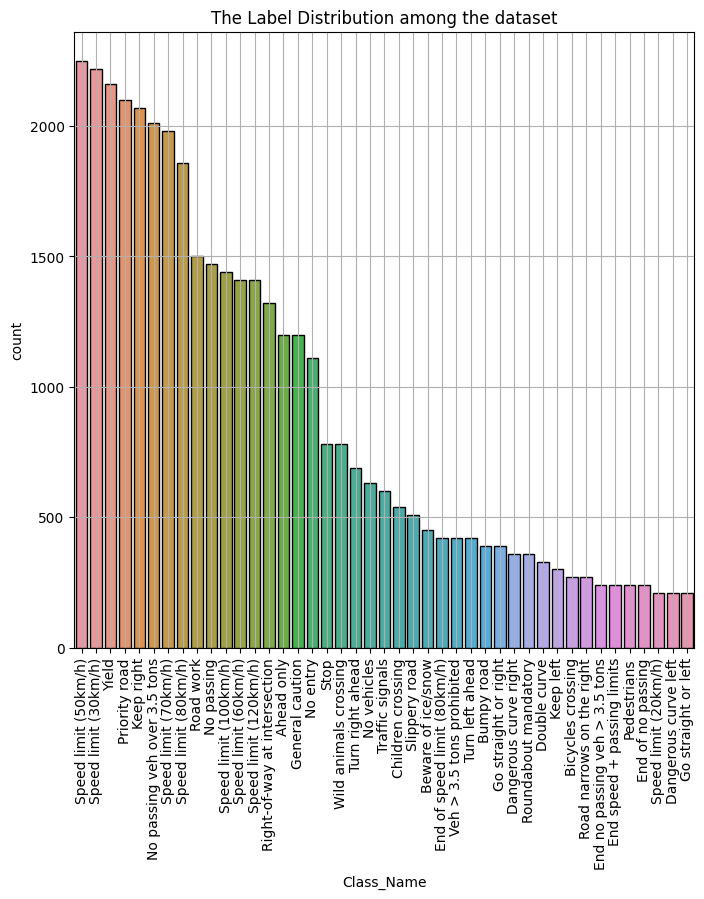

In [103]:
# %% Getting the number of values of each class present in the training:

distribution = pd.read_csv(r'/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
values = pd.DataFrame(distribution['ClassId'].value_counts()).reset_index()
values['Class_Name'] = values['ClassId'].map(classes_labels)

print(values['count'].max())
print(values['count'].min())

classes = values['ClassId'].nunique()

plt.figure(figsize=(8, 8))
sn.barplot(y = values['count'], x = values['Class_Name'], edgecolor='black')
plt.xticks(rotation = 90)
plt.title("The Label Distribution among the dataset")
plt.grid(True)
plt.show()

# The Data is getting skewed and the distribution is unequal. 
# Thus we match it up with data arguementation.

The size of the train images: (32, 128, 128, 3)


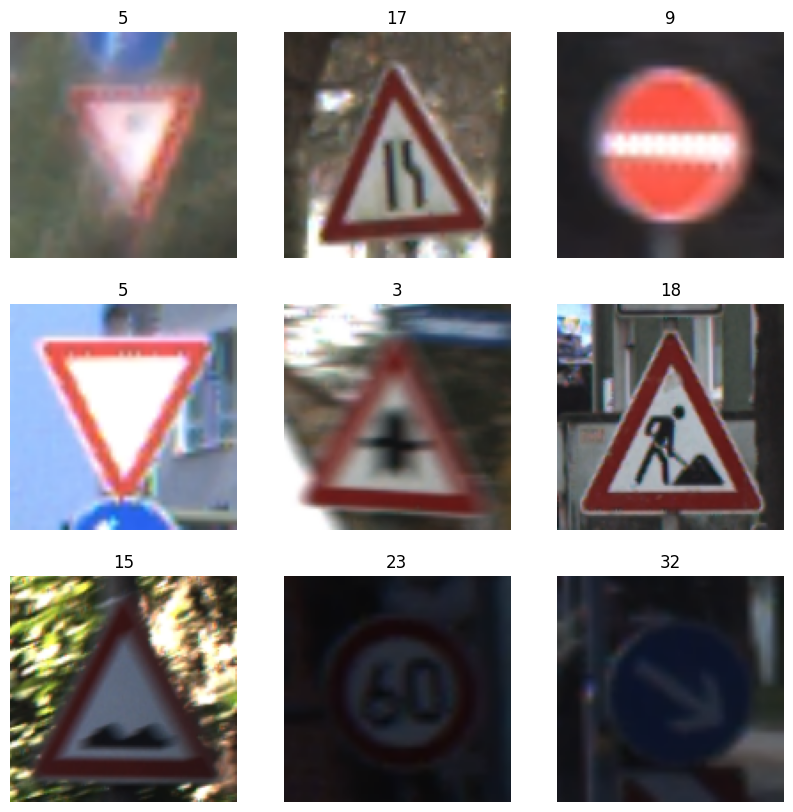

In [104]:
# %% Plotting the images with the label:
    
train_selector = train.as_numpy_iterator()
train_selector = train_selector.next()

print(f'The size of the train images: {train_selector[0].shape}')
numbers = 9 # Any perfect square number
i = 1

plt.figure(figsize=(10, 10))

for (label, image) in enumerate(train_selector[0][: numbers]):
    plt.subplot(np.sqrt(numbers).astype('int64'), np.sqrt(numbers).astype('int64'), i)
    plt.imshow(image.astype('int64'))
    plt.title(train_selector[1][label])
    plt.axis('off')
    i += 1
plt.show()

In [105]:
# %% Splitting the train and validation data from training:

train_ratio = 0.8
dataset_size = len(train)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size

train_set = train.take(train_size)
validation_set = train.skip(train_size).take(validation_size)

print(f'The Train dataset size: {len(train_set)*32}')
print(f'The Validation dataset size: {len(validation_set)*32}')

The Train dataset size: 25088
The Validation dataset size: 6304


In [106]:
# %% Building the CNN Architecture for the Prediction:

model = Sequential([
    Input(shape=(128, 128, 3)),
    
    Rescaling(1.0/255.0),
    
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    
    #GlobalAveragePooling2D(),
    Flatten(),
    
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=classes, activation='softmax')
])


print(model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,787 (1.25 MB)

 Trainable params: 327,307 (1.25 MB)

 Non-trainable params: 480 (1.88 KB)

None


In [107]:
# Compiling the model created:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [108]:
# %% Getting the necessary Call backs:

ES = EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=1, restore_best_weights=True, patience=10, mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
MCP = ModelCheckpoint('Best_Model.keras', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')


In [109]:
# %% Training the model with the training dataset:

history = model.fit(train_set, validation_data=validation_set, epochs=30, callbacks=[ES, RLP, MCP])

Epoch 1/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5415 - loss: 1.5715
Epoch 1: val_accuracy improved from -inf to 0.92038, saving model to Best_Model.keras
784/784 ━━━━━━━━━━━━━━━━━━━━ 66s 76ms/step - accuracy: 0.5417 - loss: 1.5705 - val_accuracy: 0.9204 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 2/30
  6/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9536 - loss: 0.1573 

W0000 00:00:1723830705.480546     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


781/784 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9476 - loss: 0.1688
Epoch 2: val_accuracy improved from 0.92038 to 0.93646, saving model to Best_Model.keras
784/784 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9476 - loss: 0.1687 - val_accuracy: 0.9365 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 3/30
781/784 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9729 - loss: 0.0903
Epoch 3: val_accuracy improved from 0.93646 to 0.96815, saving model to Best_Model.keras
784/784 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9729 - loss: 0.0902 - val_accuracy: 0.9682 - val_loss: 0.1104 - learning_rate: 0.0010
Epoch 4/30
780/784 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9781 - loss: 0.0765
Epoch 4: val_accuracy did not improve from 0.96815
784/784 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9781 - loss: 0.0764 - val_accuracy: 0.9621 - val_loss: 0.1344 - learning_rate: 0.0010
Epoch 5/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9793 - loss: 0.0747
Epoch

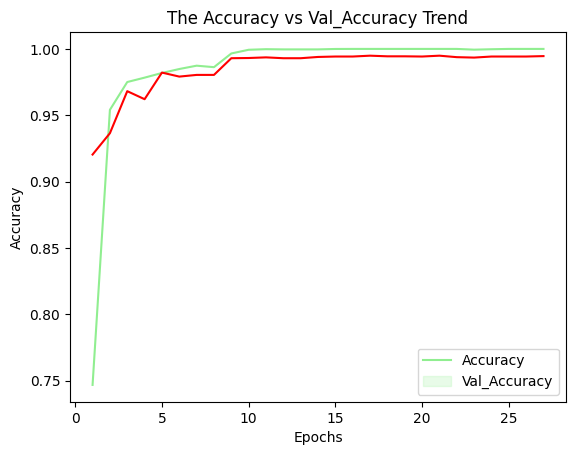

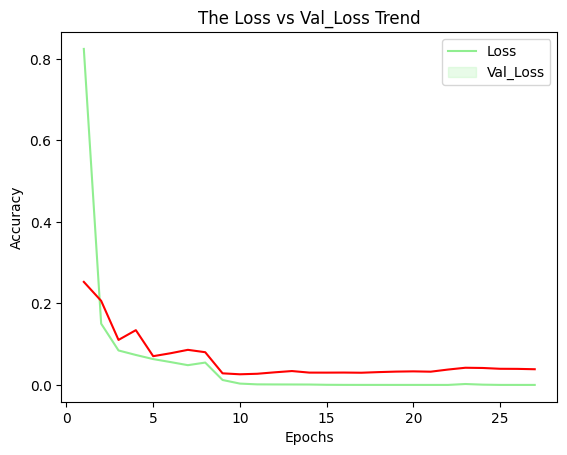

In [110]:
# %% Plotting the results of our training:

sn.lineplot(x = np.arange(1, len(history.history['accuracy'])+1), y = history.history['accuracy'], color='lightgreen')
sn.lineplot(x = np.arange(1, len(history.history['val_accuracy'])+1), y = history.history['val_accuracy'], color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("The Accuracy vs Val_Accuracy Trend")
plt.legend(labels=['Accuracy', 'Val_Accuracy'])
plt.show()

sn.lineplot(x = np.arange(1, len(history.history['accuracy'])+1), y = history.history['loss'], color='lightgreen')
sn.lineplot(x = np.arange(1, len(history.history['val_accuracy'])+1), y = history.history['val_loss'], color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("The Loss vs Val_Loss Trend")
plt.legend(labels=['Loss', 'Val_Loss'])
plt.show()

In [111]:
# %% Testing the model obtained:

loss_score, accuracy_score = model.evaluate(test)
predictions = model.predict(test)

print(accuracy_score, loss_score)

246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9940 - loss: 0.0282
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
0.9936232566833496 0.033584028482437134


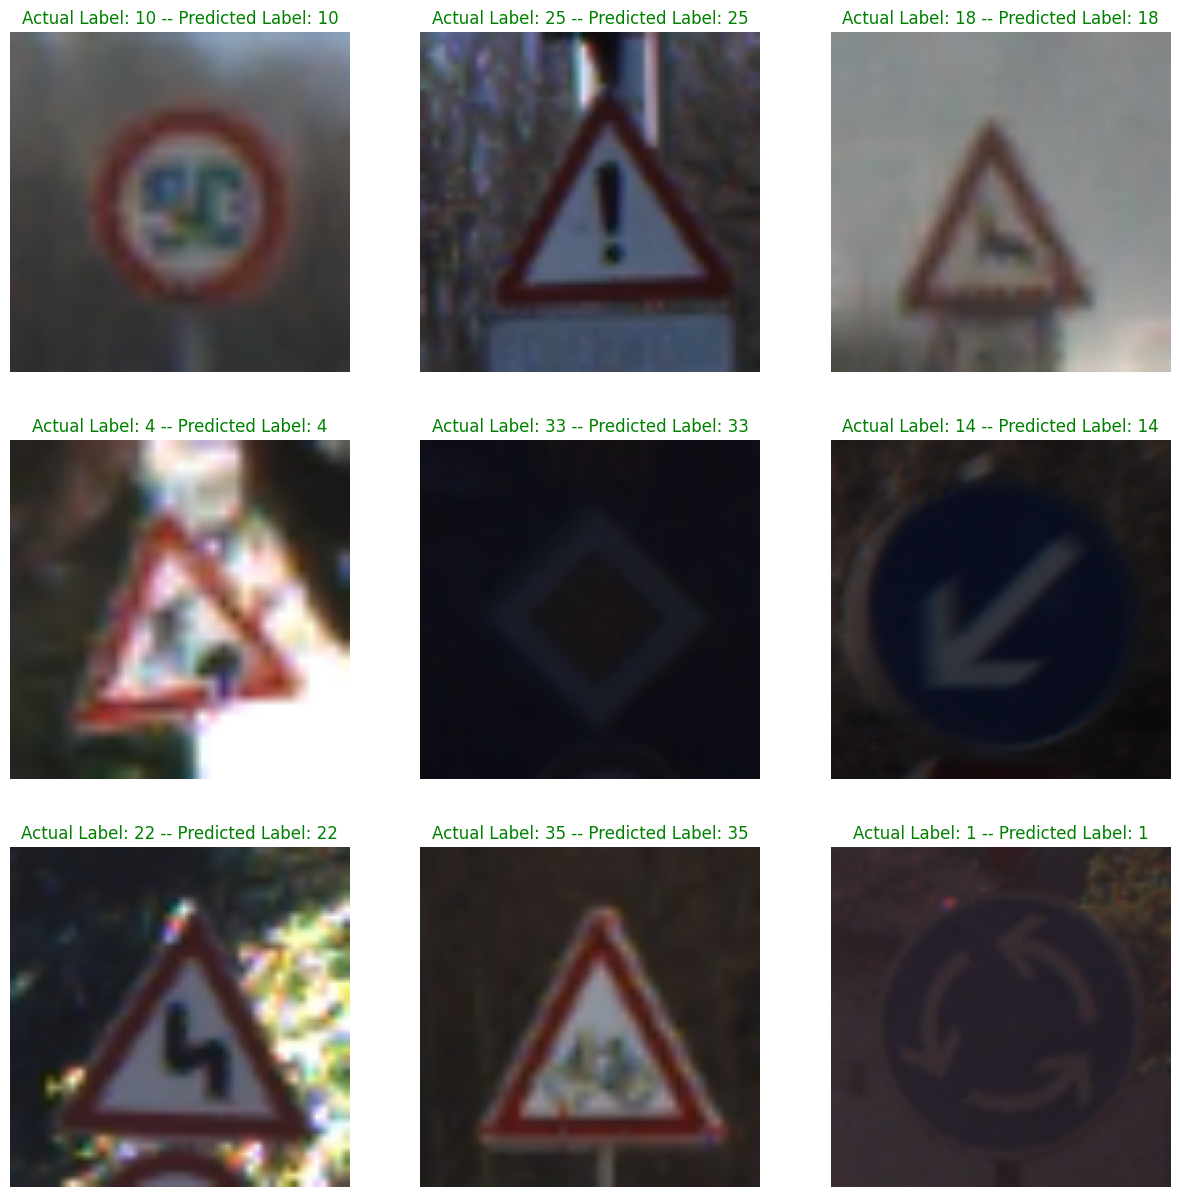

In [112]:
# %% Checking the Prediction results for our testing:

i = 1
plt.figure(figsize=(15, 15))
test_selector = test.as_numpy_iterator()
test_sel = test_selector.next()

for (label,image) in enumerate(test_sel[0][:numbers]):
    plt.subplot(np.sqrt(numbers).astype('int64'), np.sqrt(numbers).astype('int64'), i)
    plt.imshow(image.astype('int64'))
    color = 'g'
    if test_sel[1][i] != np.argmax(predictions[i]):
        color = 'r'
    plt.title(f'Actual Label: {test_sel[1][i]} -- Predicted Label: {np.argmax(predictions[i])}', color = color)
    plt.axis('off')
    i += 1
    
plt.show()

In [113]:
# %% The detailed analysis of our prediction via accuracy measures:

predicted = []
actual = []

total = 0
i = 0
test_selector = test.as_numpy_iterator()
test_sel = test_selector.next()

while True:
    actual.append(test_sel[1][i])
    i += 1
    total += 1
    if i == 32:
        i = 0
        test_sel = test_selector.next()
    if total == 7841:
        break
    
for i,j in enumerate(predictions):
    predicted.append(np.argmax(j))

print(len(predicted))
print(len(actual))


7841
7841


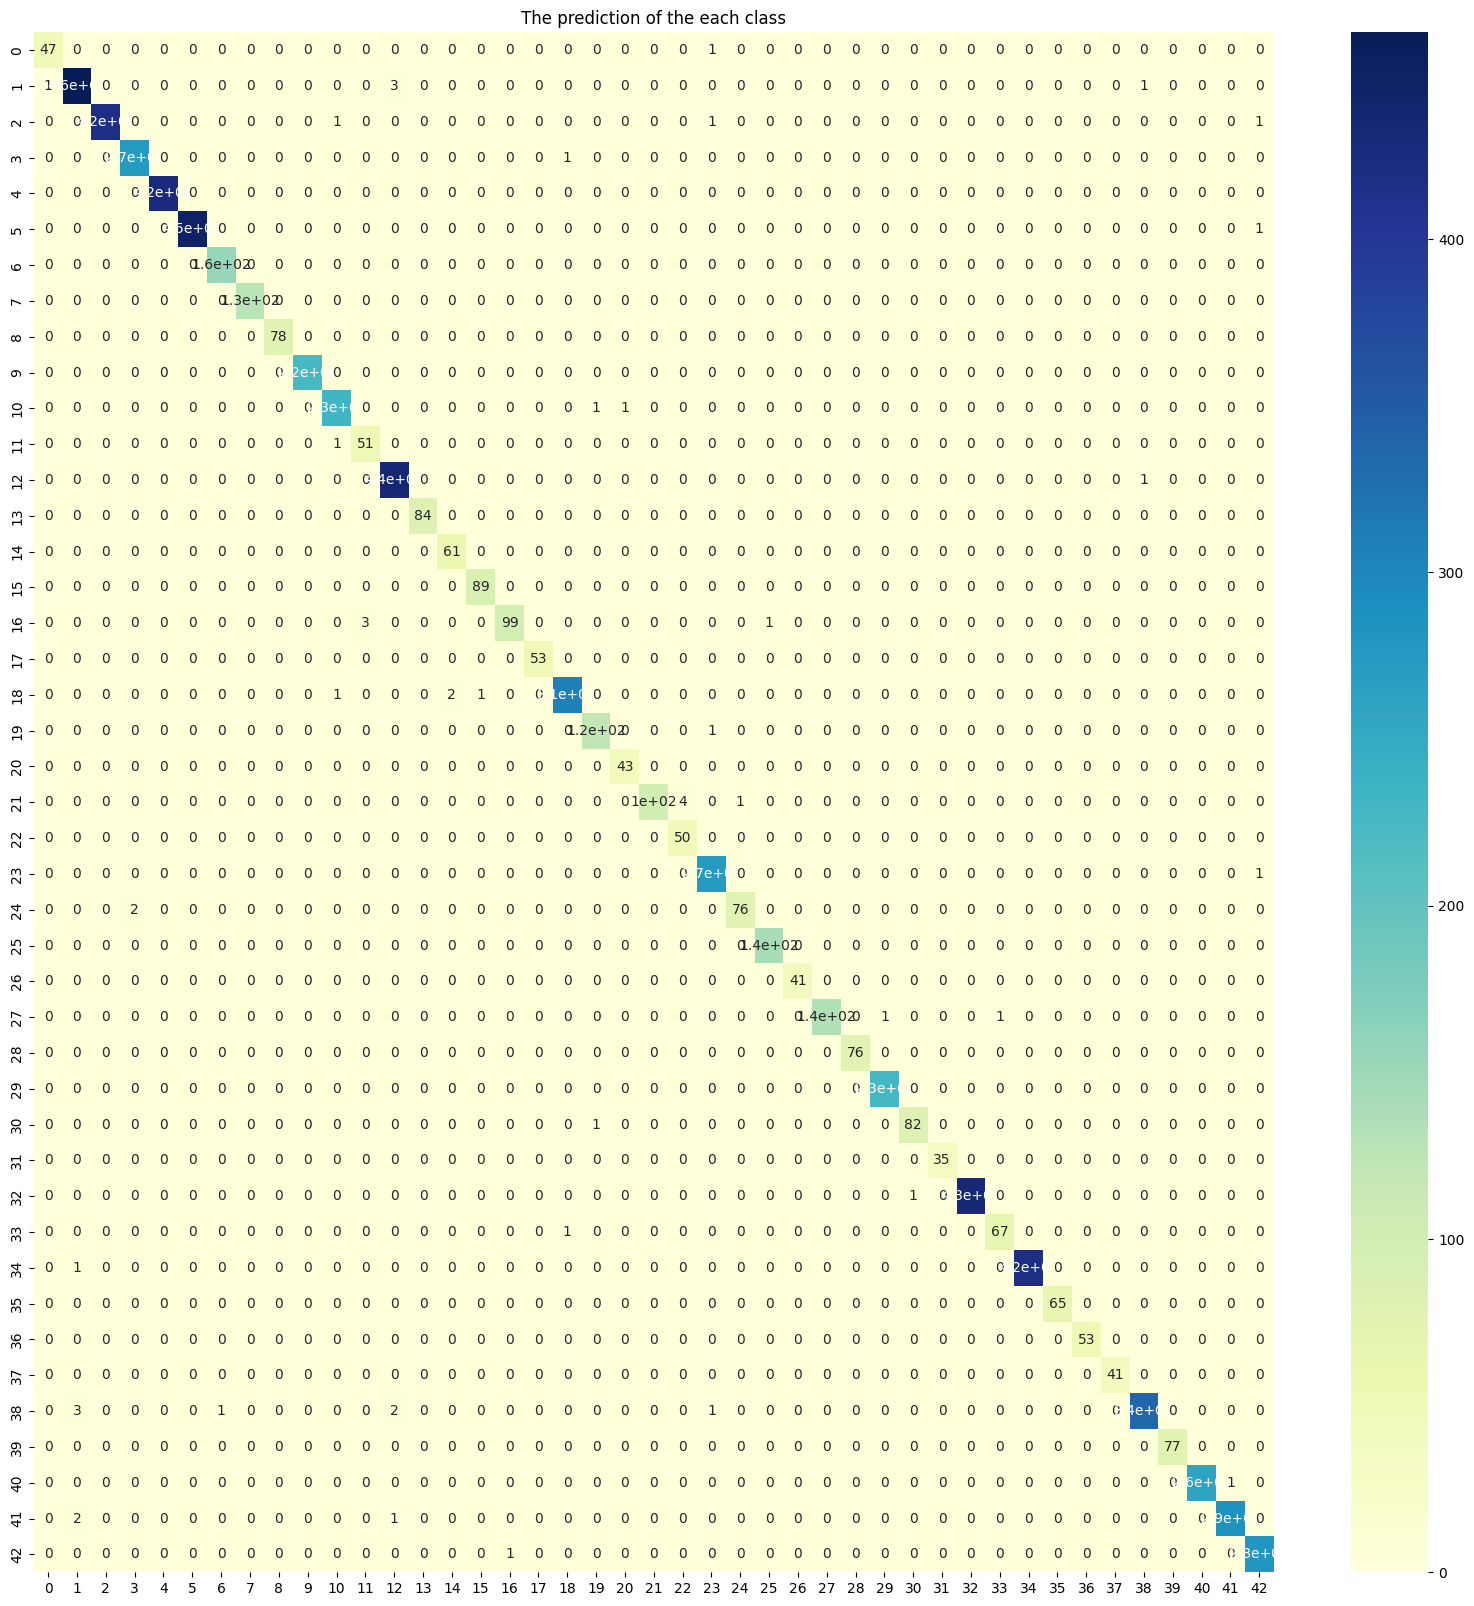

In [114]:
# %% Let's get the confusion matrix and report for our prediction:

cm = confusion_matrix(predicted, actual)

plt.figure(figsize=(20, 20))
sn.heatmap(cm, annot=True, cmap="YlGnBu", edgecolor='black')
plt.title("The prediction of the each class")
plt.show()


In [115]:
# %% Let's get the classification report for our prediction with all metrics:

report = classification_report(predicted, actual, output_dict=True)
report = pd.DataFrame(report).T.reset_index()

report_analysis = report.iloc[:43, :].sort_values(by='support', ascending=False)
print(report_analysis)

   index  precision    recall  f1-score  support
1      1   0.987179  0.989293  0.988235    467.0
5      5   1.000000  0.997778  0.998888    450.0
12    12   0.986425  0.997712  0.992036    437.0
32    32   1.000000  0.997691  0.998844    433.0
4      4   1.000000  1.000000  1.000000    425.0
2      2   1.000000  0.992874  0.996424    421.0
34    34   1.000000  0.997619  0.998808    420.0
38    38   0.994118  0.979710  0.986861    345.0
18    18   0.993528  0.987138  0.990323    311.0
41    41   0.996516  0.989619  0.993056    289.0
42    42   0.989399  0.996441  0.992908    281.0
3      3   0.992727  0.996350  0.994536    274.0
23    23   0.985560  0.996350  0.990926    274.0
40    40   1.000000  0.996183  0.998088    262.0
10    10   0.987179  0.991416  0.989293    233.0
29    29   0.995614  1.000000  0.997802    227.0
9      9   1.000000  1.000000  1.000000    225.0
6      6   0.993590  1.000000  0.996785    155.0
25    25   0.993007  1.000000  0.996491    142.0
27    27   1.000000 